In [4]:
import numpy as np
import pandas as pd
import pyjags
import math
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: No module named 'pyjags'

In [ ]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [ ]:
y_train = train['Survived']
X_train = train[['Pclass']]
X_train['Age'] = train['Age'].fillna(np.mean(train['Age']))
X_train['Sex'] = pd.Categorical(train['Sex']).codes
X_train['SibSp_log'] = train.apply(lambda row: math.log(row['SibSp'] + 1), axis=1)

X_test = test[['Pclass']]
X_test['Age'] = test['Age'].fillna(np.mean(test['Age']))
X_test['Sex'] = pd.Categorical(test['Sex']).codes
X_test['SibSp_log'] = test.apply(lambda row: math.log(row['SibSp'] + 1), axis=1)

In [ ]:
X_train.head()

In [2]:
code = '''
model {
    for (i in 1:length(y)) {
        y[i] ~ dbern(p[i])
        grp[i] = 3 * Sex[i] + Pclass[i]
        logit(p[i]) = alpha[grp[i]] + beta[grp[i]]*Age[i] + gamma[grp[i]]*SibSp_log[i]
    }
    
    for (j in 1:6) {
        alpha[j] ~ dnorm(0.0, 1.0/1.0e6)
        beta[j] ~ dnorm(0.0, 1.0/1.0e6)
        gamma[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
}
'''

In [3]:
data = dict(
    y = y_train, 
    Sex = X_train['Sex'], 
    Pclass = X_train['Pclass'], 
    Age = X_train['Age'], 
    SibSp_log = X_train['SibSp_log'])

NameError: name 'y_train' is not defined

In [7]:
model = pyjags.Model(code, data=data, chains=4)
samples = model.sample(15000, vars=['alpha', 'beta', 'gamma'])

adapting: iterations 3644 of 4000, elapsed 0:00:09, remaining 0:00:01
adapting: iterations 4000 of 4000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 3928 of 60000, elapsed 0:00:10, remaining 0:02:18
sampling: iterations 5960 of 60000, elapsed 0:00:15, remaining 0:02:13
sampling: iterations 7992 of 60000, elapsed 0:00:20, remaining 0:02:08
sampling: iterations 12052 of 60000, elapsed 0:00:30, remaining 0:01:58
sampling: iterations 16116 of 60000, elapsed 0:00:40, remaining 0:01:48
sampling: iterations 18148 of 60000, elapsed 0:00:45, remaining 0:01:43
sampling: iterations 20180 of 60000, elapsed 0:00:50, remaining 0:01:38
sampling: iterations 22212 of 60000, elapsed 0:00:55, remaining 0:01:33
sampling: iterations 26276 of 60000, elapsed 0:01:05, remaining 0:01:23
sampling: iterations 28308 of 60000, elapsed 0:01:10, remaining 0:01:18
sampling: iterations 30340 of 60000, elapsed 0:01:15, remaining 0:01:13
sampling: iterations 34404 of 60000, elapsed 0:01:25, remaining 0:01:03

In [93]:
def draw(samples, name, h, w, n):
    print(name)
    f, axarr = plt.subplots(h, w)
    f.set_size_inches(15, 15)
    for i in range(n):
        axarr[i // w, i % w].plot(samples[name][i])
    plt.show()

alpha


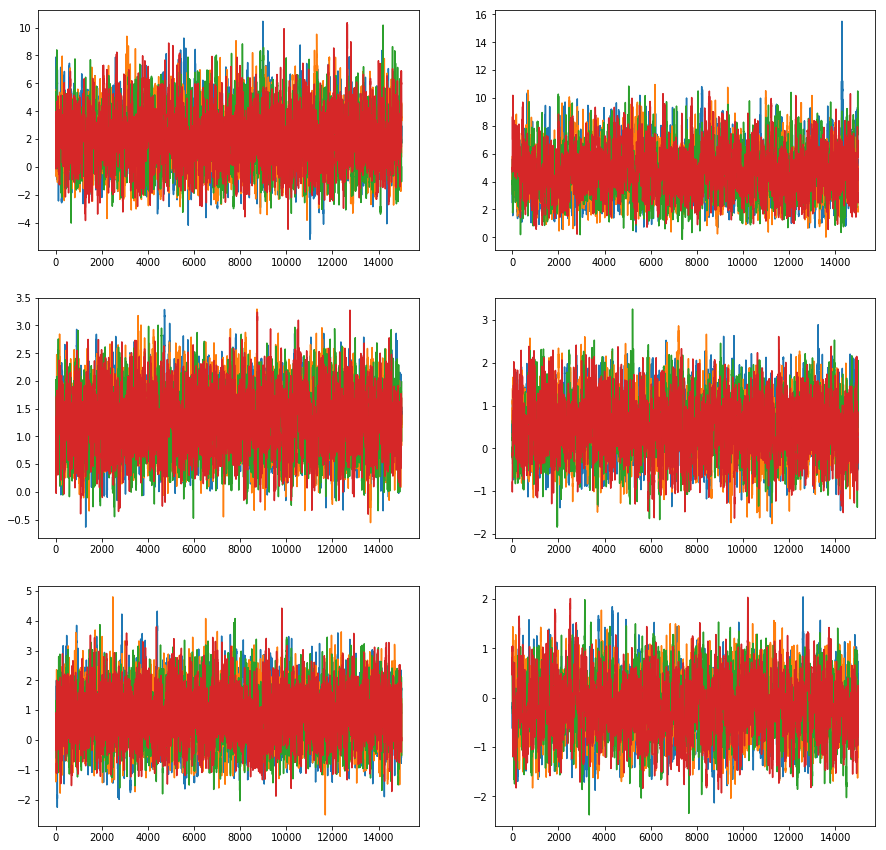

beta


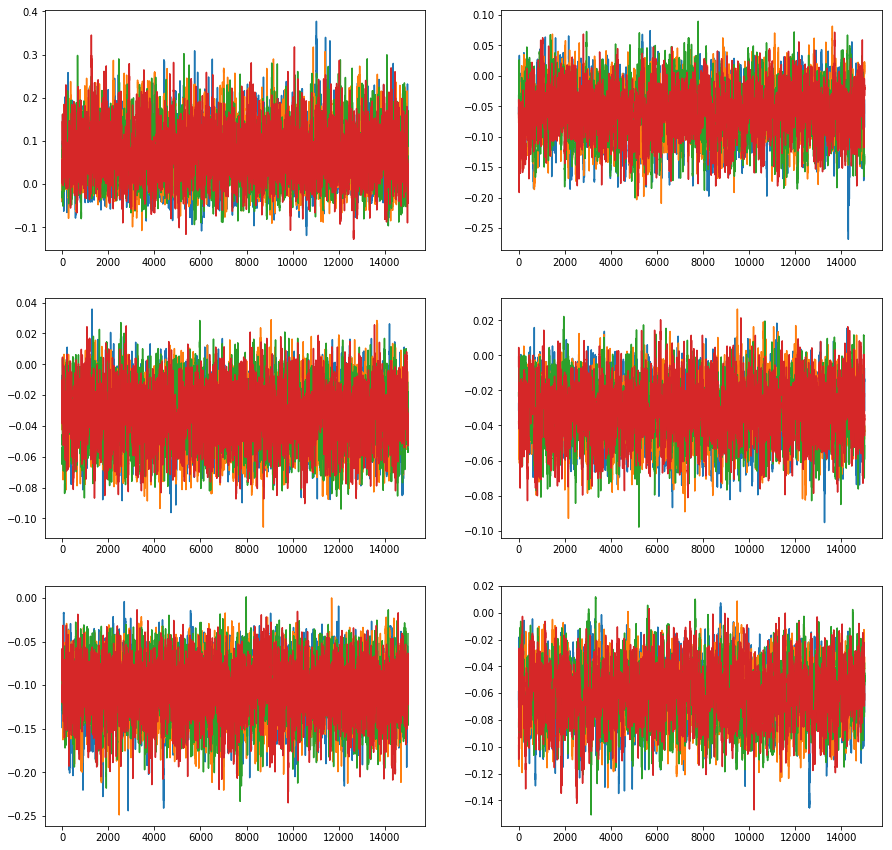

gamma


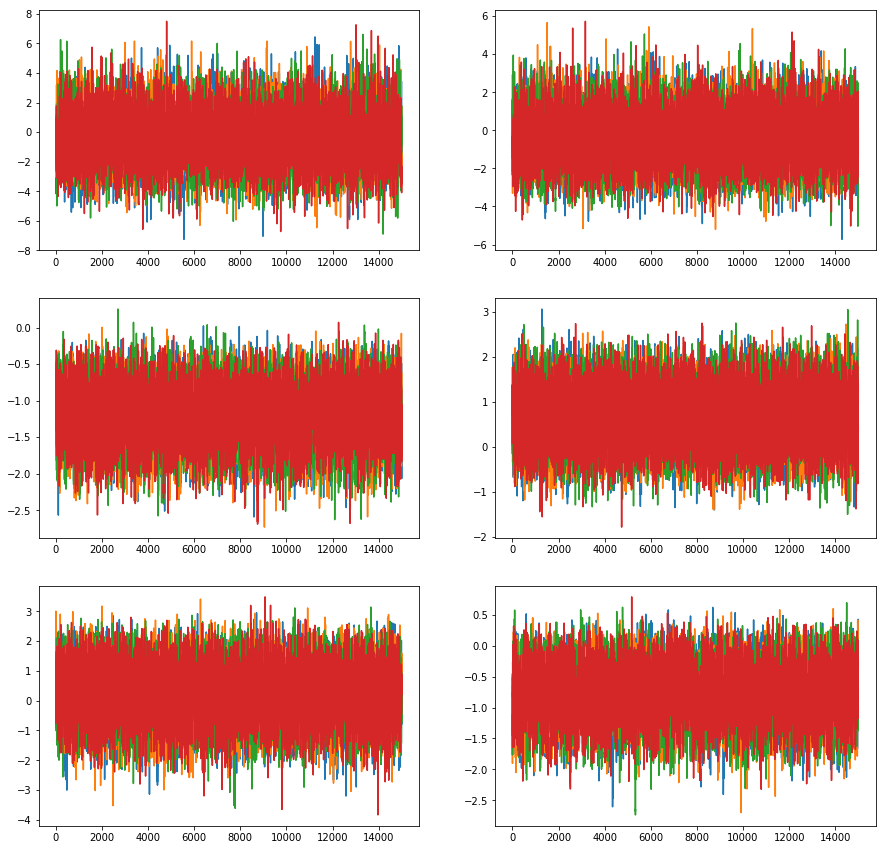

In [94]:
draw(samples, 'alpha', 3, 2, 6)
draw(samples, 'beta', 3, 2, 6)
draw(samples, 'gamma', 3, 2, 6)

In [27]:
def getMeans(samples, name):
    N = len(samples[name])
    x = np.zeros(N)
    for i in range(N):
        x[i] = np.mean(samples[name][i])
    return x

In [29]:
alpha = getMeans(samples, 'alpha')
beta = getMeans(samples, 'beta')
gamma = getMeans(samples, 'gamma')

In [31]:
print(alpha)
print(beta)
print(gamma)

[ 2.0933185   4.73889025  1.29408716  0.52601166  0.84054941 -0.17628335]
[ 0.06815692 -0.05913734 -0.03300919 -0.03168803 -0.10450022 -0.06013666]
[-0.45359794 -0.43733281 -1.18877087  0.66441474  0.24636204 -0.73512498]


In [84]:
def predict(Pclass, Age, Sex, SibSp_log):
    global alpha
    global beta
    global gamma
    
    grp = 3 * int(Sex) + int(Pclass) - 1
    t = alpha[grp] + beta[grp]*Age + gamma[grp]*SibSp_log
    p = 1.0 / (1.0 + math.exp(-t))
    
    if p > 0.5:
        return 1
    else:
        return 0  

In [85]:
predicted = X_train.apply(lambda row: predict(row['Pclass'], row['Age'], row['Sex'], row['SibSp_log']), axis=1)

In [86]:
print('Accuracy', sum(predicted == y_train) / len(y_train))

Accuracy 0.820426487093


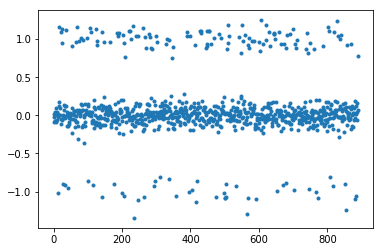

In [89]:
plt.plot(y_train - predicted + np.random.normal(0, 0.1, len(y_train)), '.')

In [91]:
# Prediction for Kaggle

test_predicted = X_test.apply(lambda row: predict(row['Pclass'], row['Age'], row['Sex'], row['SibSp_log']), axis=1)

In [92]:
def writeAnswer(filename, prediction):
    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })
    submission.to_csv(filename, index=False)
    
writeAnswer('ANOVAModel.csv', test_predicted)